In [2]:
from cmdstanpy import CmdStanModel
import arviz as az

import numpy as np
import matplotlib.pyplot as plt

import pickle

In [178]:
dp_mix_stan = """
data
{
    int I; // number of areal locations
    int T; // number of time steps
    int P; // number of covariates
    int H; // truncation of stick breaking construction dp
    
    array[I] vector[T] y; // value of interest
    array[I] matrix[T,P+1] X; // covariates matrices for each province
      
    // hyperpar vector of regressors
    vector[P+1] mu_0; 
    real        sigma_0;
    
    // mean of w_1 (random effect for every province at time 1)
    vector[I] mu_w_1;
    
    // alpha
    real a_alpha;
    real b_alpha;
    
    // tau^2
    real a_tau2;
    real b_tau2;
    
    // sigma^2
    real a_sigma2;
    real b_sigma2;
    
    // rho 
    real rho;
    
    //xis
    real a_xi;
    real b_xi;

    // Qinv
    matrix[I,I] inv_Q;
}

transformed data {
    matrix[I, I] L;
    L = cholesky_decompose(inv_Q);
}

parameters
{
    real<lower=0> alpha;
    real<lower=0> sigma2; 
    real<lower=0> tau2;  
    
    // autoregressive coefficient
    real<lower=0,upper=1> xi_constructor;
    
    // betas for the mixture of the dirichlet process
    array[H] vector[P+1] betas;

    // for the construction of the dirichlet process
    vector<lower=0,upper=1>[H-1] vs;
    
    // for the random effect construction 
    vector[I] w_raw;
}

transformed parameters
{   
    // weights stick breaking construction
    simplex[H] omegas; 
    
    // sbc stuff
    vector[H-1] cumprod_one_mv;    
    cumprod_one_mv = exp(cumulative_sum(log1m(vs)));
    
    omegas[1] = vs[1];
    omegas[2:(H-1)] = vs[2:(H-1)] .* cumprod_one_mv[1:(H-2)];
    omegas[H] = cumprod_one_mv[H-1];
    
    // xi of the random effects
    real xi = 2*xi_constructor-1;
    
    // random effects tmp
    matrix[I,T]                ws_tmp;
    
    ws_tmp[1:I,1] =  mu_w_1 + L*w_raw;
    
    for (t in 2:T)
        ws_tmp[1:I,t] = ws_tmp[1:I,t-1]*xi + L*w_raw; 
    
    matrix[T,I]   ws = (ws_tmp)'; //otherwise I have to transpose in the for loop at each iteration
    
    // Stan wants std
    real sigma = sqrt(sigma2);
    real tau = sqrt(tau2);
    
    // for each mixture and province the means for all the time
    array[H,I] vector[T] means;

    for (i in 1:I) {
        for (h in 1:H) 
            means[h,i] = X[i]*betas[h] + ws[1:T,i];
    }

}

model
{
    alpha  ~ gamma(a_alpha,b_alpha);
    sigma2 ~ inv_gamma(a_sigma2,b_sigma2);
    tau2   ~ inv_gamma(a_tau2,b_tau2);
    vs     ~ beta(1,alpha);
    w_raw ~ normal(0, tau); // does vectorization work? it is a vector it should
    xi_constructor ~ beta(a_xi,b_xi);
    
    for (h in 1:H)
        betas[h] ~ normal(mu_0, sigma_0);
    
    vector[H] log_probs;
    for (i in 1:I) {
        // si rinizializza in questo modo log_probs??
        for (h in 1:H) 
            log_probs[h] = log(omegas[h]) + 
            normal_lpdf(y[i] | means[h,i], sigma);
        
        target += log_sum_exp(log_probs);
    }
}

generated quantities 
{   
    // vector of cluster allocations
    vector[I] s;
    
    // log likelihood for each areal location 
    vector[I] log_lik;
    
    array[I] vector[H] log_probs;
    for (i in 1:I) 
    {
        for (h in 1:H) 
            log_probs[i,h] = log(omegas[h]) + 
            normal_lpdf(y[i] | means[h,i], sigma);
        
        s[i] = categorical_rng(softmax(log_probs[i]));
        log_lik[i] = log_sum_exp(log_probs[i]);
    }
    
        
}
"""

stan_file = "Sp_corr.stan"

with open(stan_file, "w") as fp:
    fp.write(dp_mix_stan)
    
dp_mix = CmdStanModel(stan_file=stan_file)

17:36:49 - cmdstanpy - INFO - compiling stan file /home/riccardo/bayesian-project/Sp_corr.stan to exe file /home/riccardo/bayesian-project/Sp_corr
17:37:18 - cmdstanpy - INFO - compiled model executable: /home/riccardo/bayesian-project/Sp_corr


In [ ]:
#The cell below is the simulated dataset from the paper (10x10)

In [1]:
np.random.seed(120) 

I = 100
T = 10
P = 3
num_clus = 7
# means = np.array([-5, 0, 5, 3, -3, -10, 10]) #vector of possible mean 
true_beta_means=np.array([[0.2, 0.2 ,0.2,0.2],[-1, -1 , -1,-1],[3, 3 ,3,3],[-2,-2,-2,-2],[5,5,5,5],[-4,-4,-4,-4],
                   [4,4,4,4]])
W_raw= np.zeros((I,I))
true_clus=np.zeros((I,1),int)

beta = np.zeros((num_clus,P+1))
for i in range(num_clus):
    beta[i,0:] = np.random.multivariate_normal(mean=true_beta_means[i],cov = np.eye(P+1));
    
#Put the i in a matrix(10x11) saved by the sequence of rows
# W(i,j)=1 if i and j have a shared side or corner
# Divided in 7 groups as in paper
Square_clus= np.zeros((10,10))
Square_clus[2:,0:4]=np.ones((8,4))
Square_clus[0:2,2:4]=2*np.ones((2,2))
Square_clus[0:8,4:]=4*np.ones((8,6))
Square_clus[0:4,4:6]=2*np.ones((4,2))
Square_clus[0:3,8:]=5*np.ones((3,2))
Square_clus[4:6,4:7]=3*np.ones((2,3))
Square_clus[8:,4:]=6*np.ones((2,6))
for i in range(I):
    W_raw[i,i]=1
    col_ind_i=int(i%10)
    row_ind_i=int((i-col_ind_i)/10)
    true_clus[i]= Square_clus[row_ind_i,col_ind_i]
    for j in range(i):
        col_ind_j=int(j%10)
        row_ind_j=int((j-col_ind_j)/10)
        
        if(abs(row_ind_i-row_ind_j)<=1 and abs(col_ind_i-col_ind_j)<=1):
            W_raw[i,j]=1
            W_raw[j,i]=1
            
#Build X random
X_tmp = np.ones((I*T,P+1)) # in this way the first column is made by one
for i in range(I*T):
  X_tmp[i,1:] = np.random.normal(loc=1,size= P) #the other P covariates are choosen randomly

X = []
for i in range(I):
    X.append(X_tmp[T*(i):T*(i+1),0:])
    
X = np.array(X)
print(X.shape)

#Build xis
tau2=0.1
rho=0.95
v=np.matmul(W_raw,np.ones((I,1)))
v=np.reshape(v,I)
invQ=np.linalg.inv(rho*(np.diag(v)-W_raw)+(1-rho)*np.eye(I))
diag_matrix_xis=0.05*np.eye(I) #diag(xis) 

for i in range(I):
  for j in range(I):
    invQ[j,i] = invQ[i,j]

#Build W temporal autoregressive element
W=np.zeros((I,T))
W[:,0]=np.random.multivariate_normal(mean=np.zeros(I),cov=invQ*tau2)
for t in range(T-1):
    W[:,t+1]=np.random.multivariate_normal(mean=np.matmul(diag_matrix_xis,W[:,t]), cov=invQ*tau2)

#Build y
y = []
y_temp = np.zeros(T)
for i in range(I): #for each areal location 
    loc= np.matmul(X[i],np.transpose(beta[true_clus[i],:]))+ np.reshape(W[i,:],(10,1))
    y_temp = np.random.multivariate_normal(mean= np.squeeze(loc), cov=np.eye(T))
    y.append(y_temp)
    # this are the data related to areal i for all time until T
    
y = np.array(y)
print(y.shape)
print(Square_clus)
plt.hist(np.reshape(y,(I*T,1)))
# print(np.linalg.eig(invQ))

print(np.var(np.reshape(y,(I*T,1))))
print(np.mean(np.reshape(y,(I*T,1))))
print(X.shape)


NameError: name 'np' is not defined

In [166]:
mu_0 = np.zeros(P+1) #as in the paper
mu_w_1 = np.zeros(I) #as in the paper
sigma_0 = 1 #covariance matrix
H = 10

data = {
    "I": I,
    "T": T,
    "P": P,
    "H": H,
    "y": y,
    "X": X,
    "mu_0": mu_0,
    "sigma_0": sigma_0,
    "mu_w_1": mu_w_1,
    "a_alpha": 3,
    "b_alpha": 2,
    "a_tau2": 3,
    "b_tau2": 2,
    "a_sigma2": 3,
    "b_sigma2": 2,
    "rho": 0.95,
    "a_xi": 1,
    "b_xi": 1,
    "inv_Q": invQ
}

In [179]:
num_chains = 4
num_iter = 2000
fit = dp_mix.sample(data
                    , iter_warmup = 2000
                    , iter_sampling = num_iter
                    , adapt_init_phase = 1500
                    , adapt_metric_window = 1500
                    , adapt_step_size = 1500
  #                  , show_console = True
                     , chains= num_chains
                    , adapt_delta=0.9
                    , step_size = 0.2
                    , max_treedepth = 100
                   )

17:38:51 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:01:19 - cmdstanpy - INFO - CmdStan done processing.


In [180]:
s = (fit.s).astype(int)

np.savetxt("posterior_s.csv", s, delimiter=",")
s.shape

(8000, 100)

/home/riccardo/.local/lib/python3.9/site-packages/arviz/plots/traceplot.py:215: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (40), generating only 20 plots
  warnings.warn(


array([[<AxesSubplot: title={'center': 'betas\n0, 0'}>,
        <AxesSubplot: title={'center': 'betas\n0, 0'}>],
       [<AxesSubplot: title={'center': 'betas\n0, 1'}>,
        <AxesSubplot: title={'center': 'betas\n0, 1'}>],
       [<AxesSubplot: title={'center': 'betas\n0, 2'}>,
        <AxesSubplot: title={'center': 'betas\n0, 2'}>],
       [<AxesSubplot: title={'center': 'betas\n0, 3'}>,
        <AxesSubplot: title={'center': 'betas\n0, 3'}>],
       [<AxesSubplot: title={'center': 'betas\n1, 0'}>,
        <AxesSubplot: title={'center': 'betas\n1, 0'}>],
       [<AxesSubplot: title={'center': 'betas\n1, 1'}>,
        <AxesSubplot: title={'center': 'betas\n1, 1'}>],
       [<AxesSubplot: title={'center': 'betas\n1, 2'}>,
        <AxesSubplot: title={'center': 'betas\n1, 2'}>],
       [<AxesSubplot: title={'center': 'betas\n1, 3'}>,
        <AxesSubplot: title={'center': 'betas\n1, 3'}>],
       [<AxesSubplot: title={'center': 'betas\n2, 0'}>,
        <AxesSubplot: title={'center': '

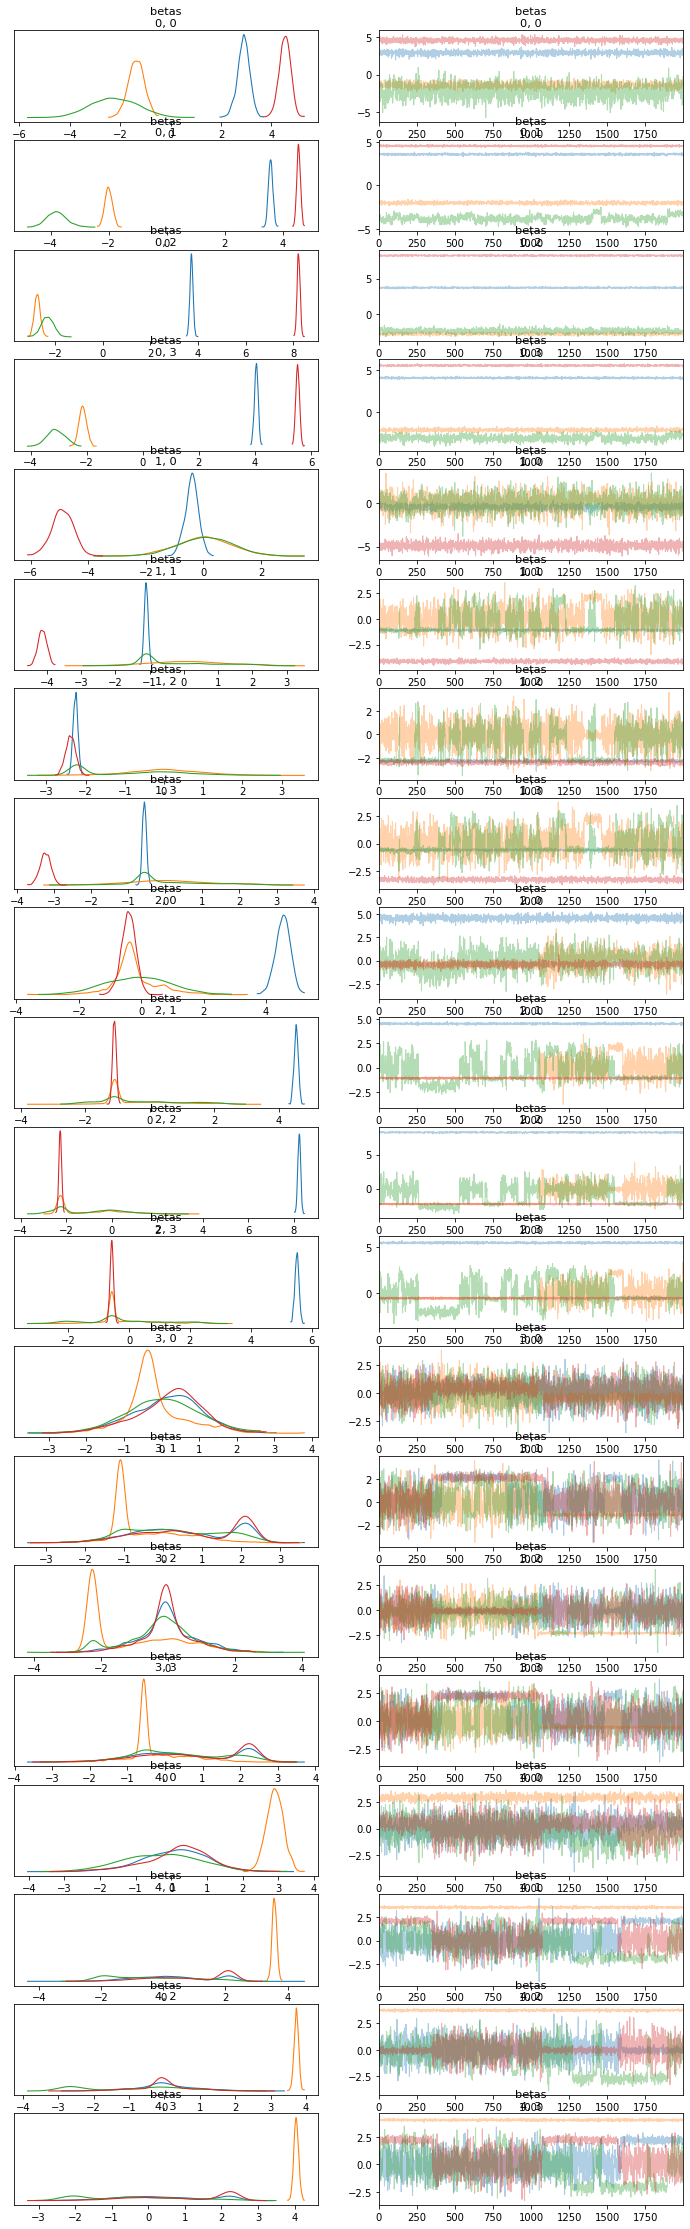

In [185]:
fit_az = az.from_cmdstanpy(fit)
az.plot_trace(fit_az,var_names=["betas"], compact = False)
plt.show()

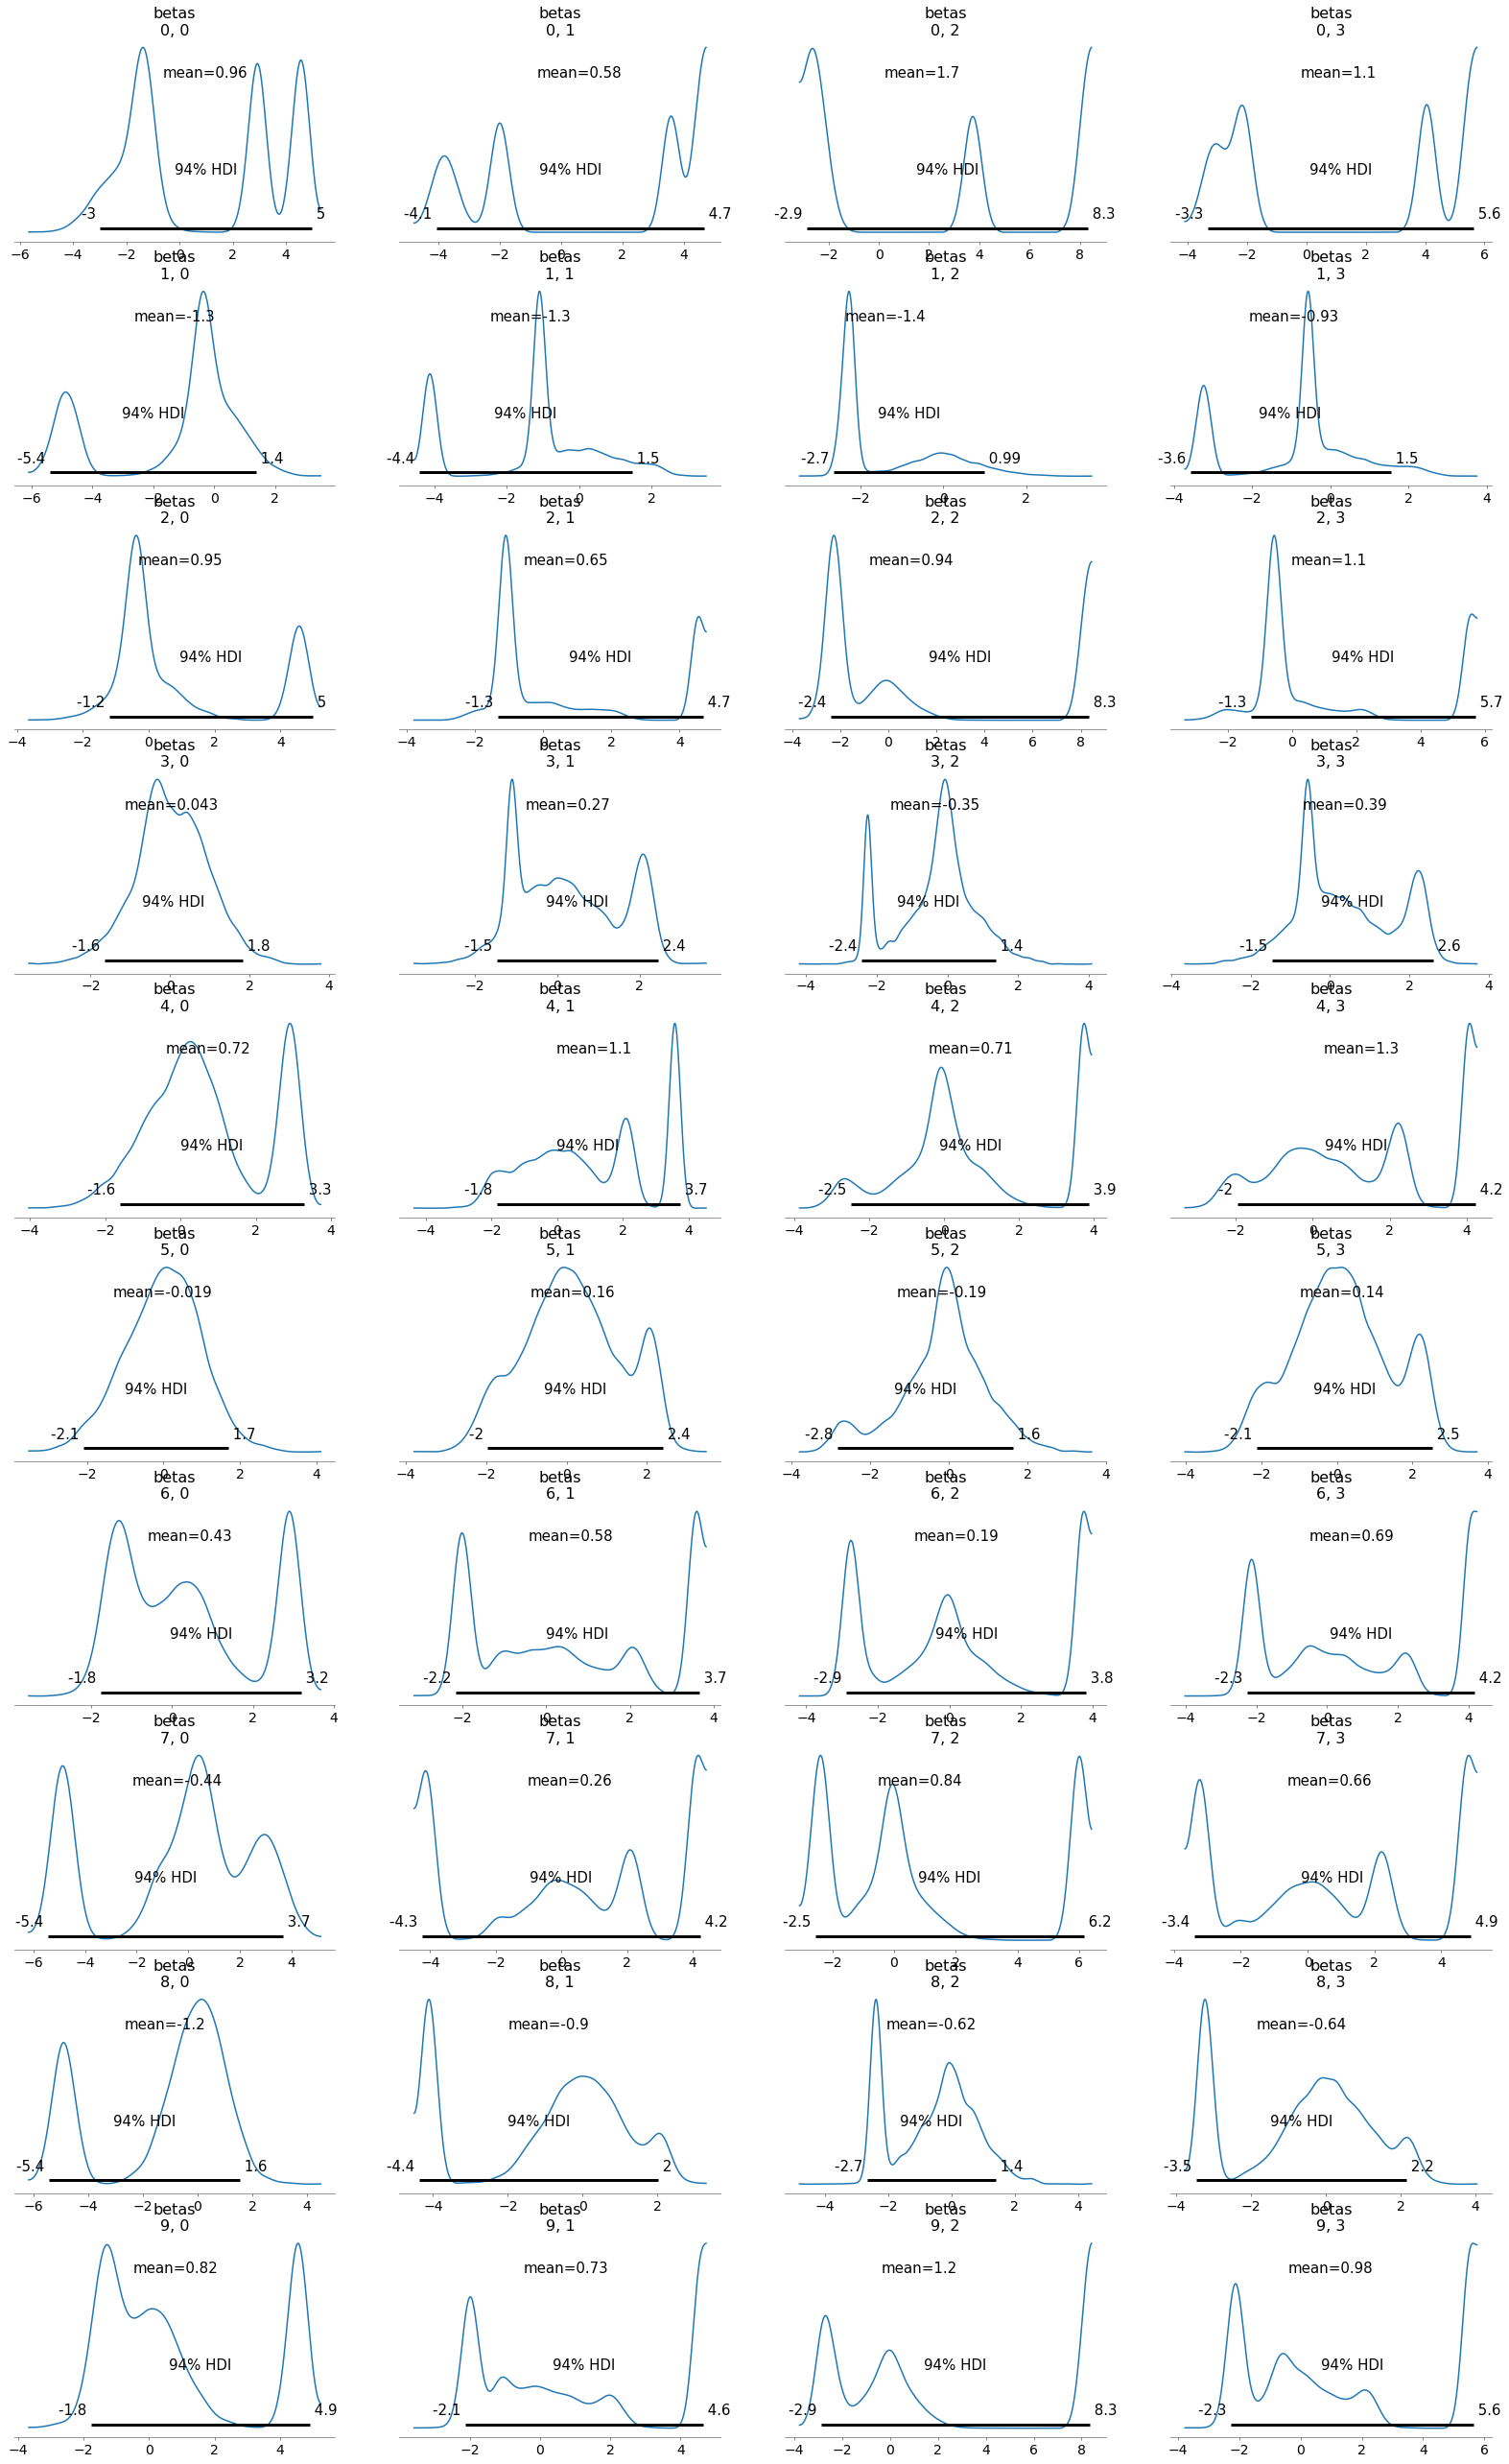

In [186]:
fit_az = az.from_cmdstanpy(fit)
az.plot_posterior(fit_az,var_names=["betas"])
plt.show()

/home/riccardo/.local/lib/python3.9/site-packages/arviz/plots/plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (53100) in plot_autocorr, generating only 40 plots
  warnings.warn(


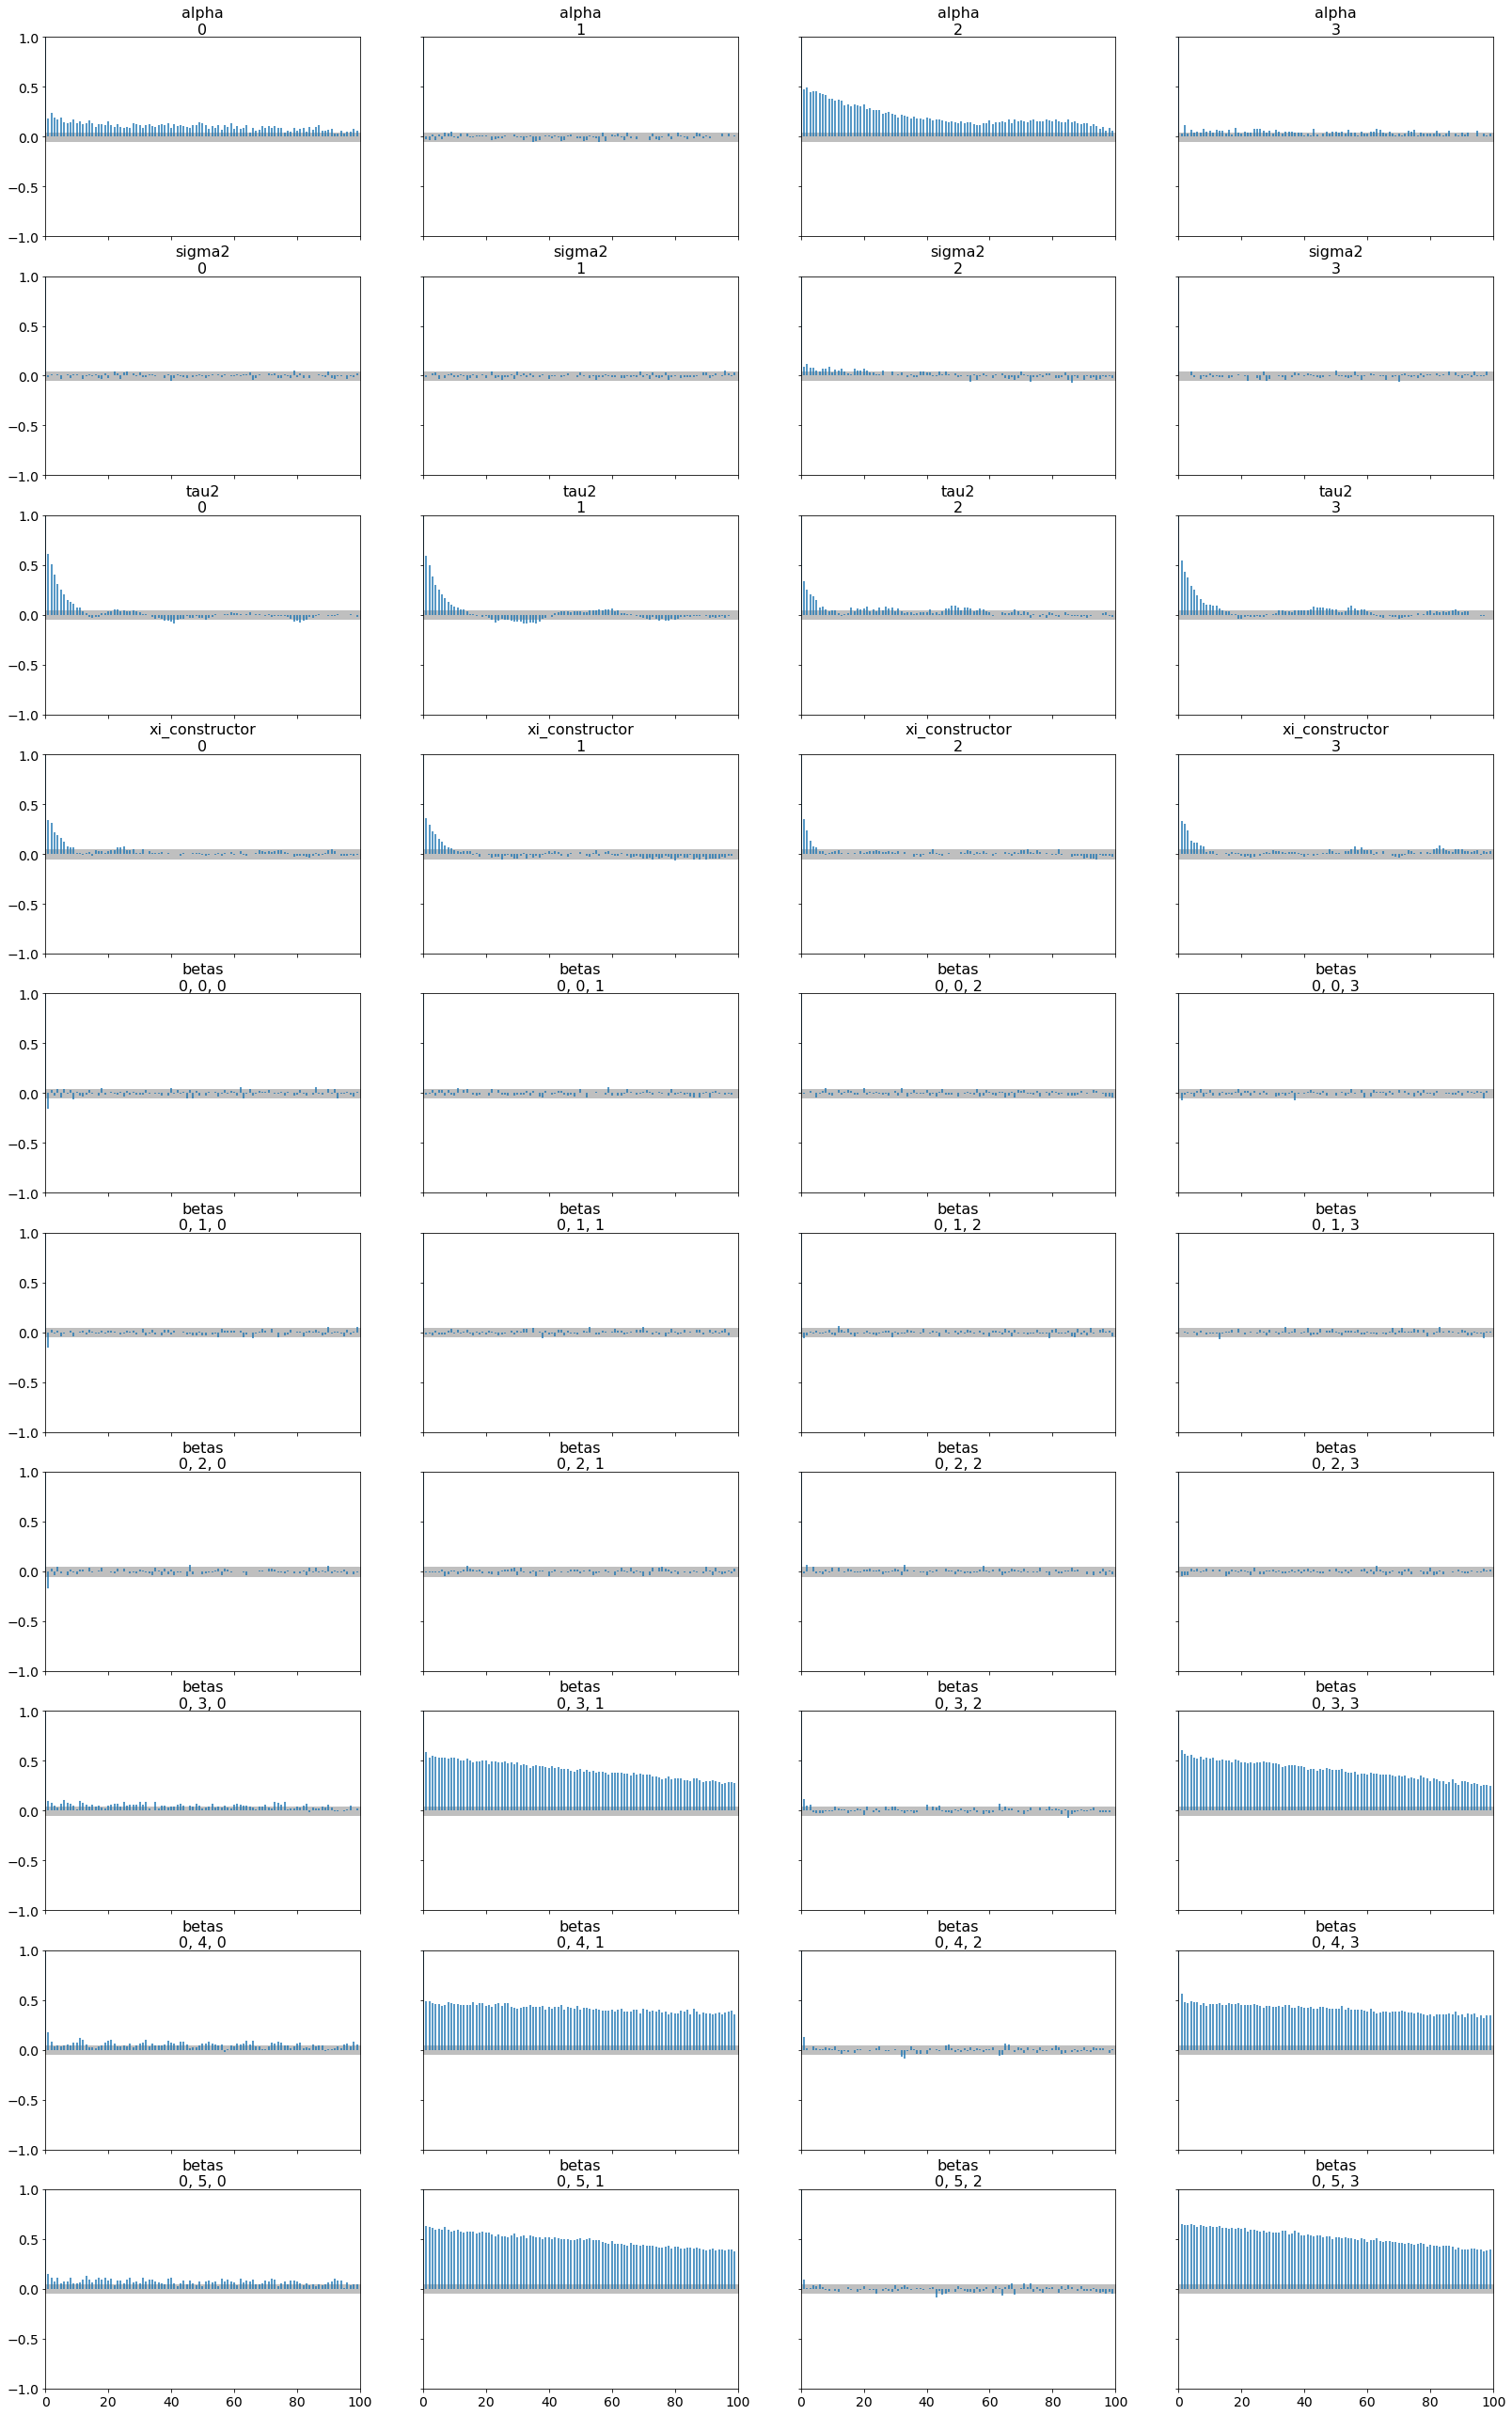

In [187]:
az.plot_autocorr(fit_az)
plt.show()
# alcuni autocorrelation plot dei beta fanno schifo :(

In [207]:
az.ess(fit_az)
# non sembrano male ma non saprei 

<xarray.Dataset>
Dimensions:               (betas_dim_0: 10, betas_dim_1: 4, vs_dim_0: 9,
                           w_raw_dim_0: 100, omegas_dim_0: 10,
                           cumprod_one_mv_dim_0: 9, ws_tmp_dim_0: 100,
                           ws_tmp_dim_1: 10, ws_dim_0: 10, ws_dim_1: 100,
                           means_dim_0: 10, means_dim_1: 100, means_dim_2: 10,
                           s_dim_0: 100, log_probs_dim_0: 100,
                           log_probs_dim_1: 10)
Coordinates: (12/16)
  * betas_dim_0           (betas_dim_0) int64 0 1 2 3 4 5 6 7 8 9
  * betas_dim_1           (betas_dim_1) int64 0 1 2 3
  * vs_dim_0              (vs_dim_0) int64 0 1 2 3 4 5 6 7 8
  * w_raw_dim_0           (w_raw_dim_0) int64 0 1 2 3 4 5 ... 94 95 96 97 98 99
  * omegas_dim_0          (omegas_dim_0) int64 0 1 2 3 4 5 6 7 8 9
  * cumprod_one_mv_dim_0  (cumprod_one_mv_dim_0) int64 0 1 2 3 4 5 6 7 8
    ...                    ...
  * means_dim_0           (means_dim_0) int64 0 1 2 3 4 5 6 7 8 9
  * means_dim_1           (means_dim_1) int64 0 1 2 3 4 5 ... 94 95 96 97 98 99
  * means_dim_2           (means_dim_2) int64 0 1 2 3 4 5 6 7 8 9
  * s_dim_0               (s_dim_0) int64 0 1 2 3 4 5 6 ... 93 94 95 96 97 98 99
  * log_probs_dim_0       (log_probs_dim_0) int64 0 1 2 3 4 5 ... 95 96 97 98 99
  * log_probs_dim_1       (log_probs_dim_1) int64 0 1 2 3 4 5 6 7 8 9
Data variables: (12/17)
    alpha                 float64 10.76
    sigma2                float64 7.148
    tau2                  float64 7.178
    xi_constructor        float64 12.72
    betas                 (betas_dim_0, betas_dim_1) float64 4.897 ... 5.324
    vs                    (vs_dim_0) float64 5.803 6.181 5.033 ... 6.052 70.88
    ...                    ...
    ws                    (ws_dim_0, ws_dim_1) float64 26.59 48.06 ... 7.127
    sigma                 float64 7.148
    tau                   float64 7.178
    means                 (means_dim_0, means_dim_1, means_dim_2) float64 4.6...
    s                     (s_dim_0) float64 33.67 33.51 4.016 ... 4.016 4.016
    log_probs             (log_probs_dim_0, log_probs_dim_1) float64 4.929 .....

In [209]:
fit_az.posterior.s.values[0,1999,:]
print(fit_az.posterior.s.values[0,1999,:])
print(np.reshape(true_clus,(1,100))[0])


[5. 5. 1. 1. 1. 1. 3. 3. 8. 8. 5. 5. 1. 1. 1. 1. 3. 3. 8. 8. 2. 2. 2. 2.
 1. 1. 3. 3. 8. 8. 2. 2. 2. 2. 1. 1. 3. 3. 3. 3. 2. 2. 2. 2. 7. 7. 7. 3.
 3. 3. 2. 2. 2. 2. 7. 7. 7. 3. 3. 3. 2. 2. 2. 2. 3. 3. 3. 3. 3. 3. 2. 2.
 2. 2. 3. 3. 3. 3. 3. 3. 2. 2. 2. 2. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 1. 1.
 1. 1. 1. 1.]
[0 0 2 2 2 2 4 4 5 5 0 0 2 2 2 2 4 4 5 5 1 1 1 1 2 2 4 4 5 5 1 1 1 1 2 2 4
 4 4 4 1 1 1 1 3 3 3 4 4 4 1 1 1 1 3 3 3 4 4 4 1 1 1 1 4 4 4 4 4 4 1 1 1 1
 4 4 4 4 4 4 1 1 1 1 6 6 6 6 6 6 1 1 1 1 6 6 6 6 6 6]


In [68]:
with open("spatially_correlated_simulated_dataset.pkl", "wb") as f:
    pickle.dump({'model' : dp_mix, 'fit' : fit}, f, protocol=-1)
    # or with a list
    pickle.dump([dp_mix, fit], f, protocol=-1)
fit_az = az.from_cmdstanpy(fit)

In [189]:
#Extimate pi[i,j] to compute Binder loss
#Likely not the most clever way to compute the matrix

n_iteration_per_chain= num_iter
Binder_matrix= np.zeros((I,I))
for n in range(num_chains):
    for m in range(n_iteration_per_chain):
        for i in range(I):
            for j in range(i-1):
                if(fit_az.posterior.s.values[n,m,i]==fit_az.posterior.s.values[n,m,j]):
                    Binder_matrix[i,j]+=1
                
Binder_matrix= Binder_matrix/(n_chains*n_iteration_per_chain)


KeyboardInterrupt: 

In [11]:
#define Binder Loss

#Commented I added a penalty for a large number of clusters
#With penalty_n_clus=0 standard binder loss

def binder_function(binder_alloc):
    loss=0
    #penalty_n_clus=1
    #loss=penalty_n_clus*np.unique(binder_alloc).size
    
    for i in range(I):
        for j in range(i):
            
            if(binder_alloc[i]==binder_alloc[j]):
                    loss+=(1-Binder_matrix[i,j])
            
            else:
                loss+=(Binder_matrix[i,j])
            
    return loss

    

In [12]:
#Minimize Binder Loss evaluating the loss only 
#in the solutions found by stan model
#Not completly correct but should be a good doable approximation
n_chains=4
iteration_per_chain=1000
min_loss=10000
s_fixed=np.zeros(I)
for n in range(n_chains):
    for m in range(iteration_per_chain):
        loss=binder_function(fit_az.posterior.s.values[n,m])
        if(loss<min_loss):
            s_fixed=fit_az.posterior.s.values[n,m]

print('S_fixed')
print(s_fixed)


S_fixed
[ 8. 10.  9.  6.  7.  1.  2.  7.  1. 10. 10.  6.  1. 10. 10.  1.  7.  7.
  2.  1.  1.  9.  8.  6.  1.  6.  2.  4.  2.  7.  7.  3.  1. 10.  6.  9.
  4.  8.  3.  2.  1.  3.  5.  4.  4.  5.  8.  2.  7.  9.  8.  1.  3.  8.
  3.  8.  5.  1.  5.  7.  6. 10.  4. 10.  7.  7.  2. 10. 10.  5. 10.  8.
  3.  3.  2.  5.  5.  3.  3.  9.  7.  5. 10.  6. 10.  1.  1.  1. 10.  1.
 10.  1.  1.  2.  1. 10. 10. 10. 10.  3.]


In [ ]:
# Fixed clustering s to study betas depending on clusters
beta_clus_stan = """
data
{
    int<lower=1> I; // number of areal locations
    int<lower=1> T; // number of time steps
    int<lower=1> P; // number of covariates
    int<lower=1> H; // number of possible clusters
    
    vector[I*T]     y; // output values
    matrix[I*T,P+1] X; // covariate matrix
    // syntax: y(i,t) = y[T*(i-1) + t]
    
    matrix[I,I] W_raw; // proximity matrix
      
    // hyperpar vector of regressors
    vector[P+1]     mu_0; 
    matrix[P+1,P+1] Sigma_0;
    
    // w_1
    vector[I] mu_w_1;
    
    // alpha
    real<lower=0> a_alpha;
    real<lower=0> b_alpha;
    
    // tau^2
    real<lower=0> a_tau2;
    real<lower=0> b_tau2;
    
    // sigma^2
    real<lower=0> a_sigma2;
    real<lower=0> b_sigma2;
    
    // rho
    real<lower=0> alpha_rho;
    real<lower=0> beta_rho;
    
    //xis
    real<lower=0> a_xi;
    real<lower=0> b_xi;
    
    int s[I];
}

transformed data
{
    vector[T] ones_T;
    for (t in 1:T)
        ones_T[t] = 1;
    
    matrix[T,T] eye_T;
    eye_T = diag_matrix(ones_T);
 
    vector[I] ones_I;
    for (i in 1:I)
        ones_I[i] = 1;
    
    matrix[I,I] eye_I;
    eye_I = diag_matrix(ones_I);
        
    matrix[I,I] W;
    W = diag_matrix(W_raw*ones_I) - W_raw;
    
    
}

parameters
{
    real<lower=0> sigma2;
    real<lower=0> tau2;
    real<lower=0,upper=1> rho;
    
    
    // autoregressive coefficients still to reparametrize
    vector<lower=0,upper=1>[I]    xis_constructors;
    
    // random effects
    matrix[T,I]                ws;
    
   //Betas depend on clusters
    matrix[P+1,H]              betas_clus; 
    
    
}


model
{
    
    sigma2 ~ inv_gamma(a_sigma2,b_sigma2);
    tau2   ~ inv_gamma(a_tau2,b_tau2);
    rho    ~ beta(alpha_rho,beta_rho);
    
    
    xis_constructors ~ beta(a_xi,b_xi);
    vector[I] xis;
    xis = 2 * xis_constructors - 1; 
    matrix[I,I] inv_Q;
    inv_Q = inverse_spd(rho*W + (1-rho)*eye_I);
    
    ws[1,1:I] ~ multi_normal(mu_w_1, tau2*inv_Q);
    
    for (t in 2:T)
        ws[t,1:I] ~ multi_normal(ws[t-1,1:I]*diag_matrix(xis), tau2*inv_Q);
    
    for(h in 1:H)
    {
        betas_clus[1:P+1,h] ~ multi_normal(mu_0, Sigma_0);
    }
    for (i in 1:I){
        int clus_i=s[i]+1;
        
        y[T*(i-1)+1:i*T] ~ multi_normal(X[T*(i-1)+1:i*T, 1:P+1]*betas_clus[1:P+1,clus_i] + ws[1:T,i], sigma2*eye_T);
    }    
}

"""

stan_file = "beta_clus.stan"

with open(stan_file, "w") as fp:
    fp.write(beta_clus_stan)
    
beta_clus = CmdStanModel(stan_file=stan_file)

In [ ]:
s= s_fixed.astype(int)

data_clus = {
    "I": I,
    "T": T,
    "P": P,
    "H": H,
    "y": y,
    "X": X,
    "W_raw": W_raw,
    "mu_0": mu_0,
    "Sigma_0": Sigma_0,
    "mu_w_1": mu_w_1,
    "a_alpha": 3,
    "b_alpha": 2,
    "a_tau2": 3,
    "b_tau2": 2,
    "a_sigma2": 3,
    "b_sigma2": 2,
    "alpha_rho": 5,
    "beta_rho": 1,
    "a_xi": 1,
    "b_xi": 1,
    "s":s
}


In [ ]:
fit_clus = beta_clus.sample(data_clus
#                     , show_console = True
#                    , chains=4
#                     , adapt_delta=0.9
#                    , step_size = 1.5
#                    , max_treedepth = 100
                   )

In [ ]:
with open("spatially_correlated_beta_clus.pkl", "wb") as f:
    pickle.dump({'model' : beta_clus, 'fit' : fit_clus}, f, protocol=-1)
    # or with a list
    pickle.dump([beta_clus, fit_clus], f, protocol=-1)